# Handling coordinate reference systems in Geopandas

_This lecture assumes you already know much about map projects and **coordinate reference systems (CRS)** so we will not be spending much time explaining that_ 

Once you have figured out which map projection to use, handling coordinate reference systems, fortunately, is fairly easy in Geopandas. The library[ pyproj](https://pyproj4.github.io/pyproj/) provides additional information about a CRS, and can assist with more tricky tasks, such as guessing the unknown CRS of a data set.

In this section we will learn **how to retrieve the coordinate reference system information of a data set, and how to re-project the data into another CRS**.


**⚠️ Careful with Shapefiles**

> You might have noticed that geospatial data sets in ESRI Shapefile format are consisting of multiple files with different file extensions. The `.prj` file contains information about the coordinate reference system. Be careful not to lose it!

### Displaying the CRS of a data set 

We will continue with our data sets from the [Introduction to Geopandas](intro_to_geopandas.ipynb) section. 

In [1]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()

# define the absolute path to the data
input_data_directory = NOTEBOOK_PATH.parent / "input_data"
output_data_directory = NOTEBOOK_PATH.parent / "output_data"

In [2]:
import geopandas

districts = geopandas.read_file(
    input_data_directory / "zwe_adm1.gpkg"
    )

Let's check the data set's CRS: 

In [3]:
districts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

What we see here is, in fact, a `pyproj.CRS` object.

The EPSG code (European Petroleum Survey Group) is global standard for identifying coordinate reference systems. The number refers to an entry in the [EPSG Geodetic Parameter Dataset](http://www.epsg.org/), a collection of coordinate reference systems coordinate transformations ranging from global to national, regional, and local scope.

Our `GeoDataFrame`’s EPSG code is `4326`. This is number to remember, as you will come across it a lot in the geospatial world: It refers to a geographic coordinate system using the WGS-84 reference ellipsoid. This is the most commonly used coordinate reference system in the world. It’s what we refer to when we speak of longitude and latitude.

You can find information about reference systems and lists of commonly known CRS from many online resources, for example:

- [spatialreference.org](http://spatialreference.org/)
- [proj4.org](https://proj4.org/operations/projections/)
- [mapref.org](http://mapref.org/CollectionofCRSinEurope.html)

### Reprojecting a `GeoDataFrame` 

A geographic coordinate system, EPSG:4326, is not particularly well-suited for making geometric based calculations like area (as you have seen previously). Distortion is also high in some places like when you have European data. 

Rather, we could use the **Arc 1950 / UTM Zone 36S** (sometimes we can use Zone 35S or 34S depending on which of the country we are working on)  projection, such as `EPSG:20936`, the map projection that is used in Zimbabwe.

Transforming data from one reference system to another is a very simple task in geopandas. In fact, all you have to to is use the `to_crs()` method of a `GeoDataFrame`, supplying a new CRS in a wide range of possible formats. The easiest is to use an EPSG code:

In [4]:
districts_20936 = districts.to_crs("EPSG:20936")

Let's check the coordinate values now and before: 

In [5]:
# before 
districts.geometry.head()

0    MULTIPOLYGON (((28.65061 -20.05229, 28.64984 -...
1    MULTIPOLYGON (((31.11632 -17.69132, 31.11631 -...
2    MULTIPOLYGON (((32.99432 -17.24570, 32.99801 -...
3    MULTIPOLYGON (((30.42240 -15.61854, 30.42243 -...
4    MULTIPOLYGON (((32.92368 -16.69346, 32.92383 -...
Name: geometry, dtype: geometry

In [6]:
# now 
districts_20936.geometry.head()

0    MULTIPOLYGON (((44846.488 7777100.886, 44783.2...
1    MULTIPOLYGON (((300217.057 8043267.139, 300216...
2    MULTIPOLYGON (((499399.065 8093564.278, 499790...
3    MULTIPOLYGON (((223623.439 8271883.849, 223716...
4    MULTIPOLYGON (((491865.631 8154654.081, 491881...
Name: geometry, dtype: geometry

And here we go, the coordinate values in the geometries have changed! Congratulations on carrying out your very first geopandas coordinate transformatin?!

**You can now calculate an accurate area** 

Let's check it out 

In [8]:
# print area of that first district again 
print(f"Area: {districts_20936.at[0, 'geometry'].area} m².")

Area: 548258820.3103054 m².


Notice this time we used `m²` to represent the area because we know the units now. 

To better grasp what exactly we have just done, it is a good idea to explore our data visually. Let’s plot our data set both before and after the coordinate transformation. We will use `matplotlib`’s `subplots` feature. 

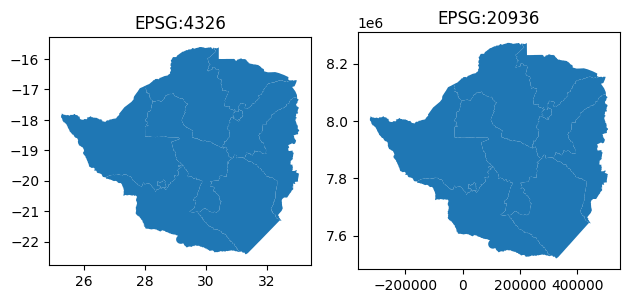

In [9]:
import matplotlib.pyplot 

# prepare sub plots that are next to each other 
figure, (axis1, axis2) = matplotlib.pyplot.subplots(nrows=1, ncols=2)

# plot the original (WGS84, EPSG:4326) data set 
districts.plot(ax=axis1)
axis1.set_title("EPSG:4326")
axis1.set_aspect(1)

# plot the reprojected (EPSG:20936) data set 
districts_20936.plot(ax=axis2)
axis2.set_title("EPSG:20936")
axis2.set_aspect(1)

matplotlib.pyplot.tight_layout()

There is not much change to the apperance but I am sure you do notice the change in scale. 

Let’s still save the reprojected data set in a file so we can use it later. Note that, even though modern file formats save the CRS reliably, it is a good idea to use a descriptive file name that includes the reference system information.

In [10]:
districts_20936.to_file(
    input_data_directory / "districts_EPSG20936.gpkg"
)

And with that, we have a new file in the projection we want it to be in. Great! 